# **Build a machine learning model**


# **PACE stages**

## **PACE: Plan**

The team is being asked to build and test random forest and XGBoost models using Waze user data, and to report on the variables used and model accuracy. Ethical implications must be considered, as prediction errors can impact business decisions. A false negative may lead to lost users due to missed retention efforts, while a false positive may result in wasted resources on users who would have stayed anyway. While these risks exist, the benefits—such as improving retention and guiding strategy—are seen to outweigh potential downsides. Therefore, the request to build the models should be proceeded with, provided performance is evaluated carefully and results are interpreted with caution.

### **Imports and data loading**

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Let's inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## **PACE: Analyze**

### **Feature engineering**

We have already prepared much of this data and performed exploratory data analysis (EDA) in previous courses. We know that some features had stronger correlations with churn than others, and we also created some features that may be useful.
Now, we'll engineer these features and some new features to use for modeling.

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

1. First, we will create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2. Get descriptive statistics for this new feature

In [6]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [7]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['km_per_driving_day'].replace(np.inf, 0)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

1. Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [8]:
# Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = (df['sessions'] / df['total_sessions']) * 100

# Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean        44.925534
std         28.691863
min          0.000000
25%         19.622145
50%         42.309703
75%         68.721626
max        153.063707
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

It's  a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [9]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] > 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**

Now, let's create a new column that represents the mean number of sessions per day _since onboarding_.

In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, get descriptive statistics for this new feature.

In [11]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, we a going to create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [14]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (
    (df['total_navigations_fav1'] + df['total_navigations_fav2']) /
    df['total_sessions']
) * 100

# Display descriptive statistics
print(df['percent_of_sessions_to_favorite'].describe())


count    14999.000000
mean       166.543919
std        886.566603
min          0.000000
25%         20.347103
50%         64.981807
75%        163.852641
max      77756.362912
Name: percent_of_sessions_to_favorite, dtype: float64


### **Drop missing values**

Because we know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, we can use the `dropna()` method to drop the rows that are missing this data.

In [15]:
# Drop rows with missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14299 non-null  int64  
 1   label                            14299 non-null  object 
 2   sessions                         14299 non-null  int64  
 3   drives                           14299 non-null  int64  
 4   total_sessions                   14299 non-null  float64
 5   n_days_after_onboarding          14299 non-null  int64  
 6   total_navigations_fav1           14299 non-null  int64  
 7   total_navigations_fav2           14299 non-null  int64  
 8   driven_km_drives                 14299 non-null  float64
 9   duration_minutes_drives          14299 non-null  float64
 10  activity_days                    14299 non-null  int64  
 11  driving_days                     14299 non-null  int64  
 12  device                 

### **Outliers**

We know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, we will need to convert it to binary, since this variable is categorical.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of special functions. We can just implement the transformation directly.

We will create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [16]:
# Create new `device2` variable
df['device2'] = df['device'].map({'Android': 0, 'iPhone': 1})

#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." 

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

We will save this variable as `label2` so as not to overwrite the original `label` variable.

In [17]:
# Create binary `label2` column
df['label2'] = df['label'].map({'retained': 0, 'churned': 1})

### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

The feature`device` won't be used simply because it's a copy of `device2`.

In [18]:
# Drop `ID` column
df = df.drop(columns=['ID'])

### **Evaluation metric**

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, let's examine the class balance of target variable.

In [19]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, let's consider which evaluation metric is best. Acuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, we will select the model based on the recall score.

## **PACE: Construct**

### **Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. We will split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set


### **Split the data**

Now we're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

In [20]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [21]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8579, 18), (8579,), (2860, 18), (2860,), (2860, 18), (2860,))

This aligns with expectations.

### **Modeling**

In [22]:
# 1. Instantiate the random forest classifier
RFC = RandomForestClassifier(class_weight='balanced', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 7, 8], 
             'max_features': ['sqrt'],
             'max_samples': [0.4, None],
             'min_samples_leaf': [3, 4],
             'min_samples_split': [2],
             'n_estimators': [90, 100, 110]
            }

# 3. Define a list of scoring metrics to capture
scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score)
}

# 4. Instantiate the GridSearchCV object
GS_RFC = GridSearchCV(estimator=RFC, param_grid=cv_params, scoring=scoring, cv=5, refit='recall')

In [23]:
%%time
GS_RFC.fit(X_train, y_train)

CPU times: user 2min 50s, sys: 1.07 s, total: 2min 52s
Wall time: 2min 52s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [6, 7, 8], 'max_features': ['sqrt'],
                         'max_samples': [0.4, None], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [2],
                         'n_estimators': [90, 100, 110]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [24]:
# Examine best score
GS_RFC.best_score_

np.float64(0.6624584717607973)

In [25]:
# Examine best combination of hyperparameters
GS_RFC.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'max_samples': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

We will use the `make_results()` function to output all of the scores of the model.

In [26]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [27]:
results_table = make_results('RFC train', GS_RFC, 'recall')
results_table

,model,precision,recall,F1,accuracy
0,RFC train,0.329969,0.662458,0.440054,0.703927


Aside from accuracy, the other scores are modest. However, compared to the logistic regression model from the previous course, which had a recall of around 0.09, this Random Forest model shows a significant improvement with a recall of approximately 0.66—over seven times higher—while maintaining similar accuracy at around 0.70, despite being trained on a smaller dataset.

#### **XGBoost**

Let's try to improve scores using an XGBoost model.

In [28]:
# 1. Instantiate the XGBoost classifier
XGB = XGBClassifier(random_state=42, objective='binary:logistic')

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [6, 7, 8],           
    'learning_rate': [0.5, 0.7, 0.8], 
    'n_estimators': [100, 120, 150]          
}

# 3. Define a list of scoring metrics to capture
scoring = {
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'accuracy': make_scorer(accuracy_score)
}

# 4. Instantiate the GridSearchCV object
GS_XGB = GridSearchCV(estimator=XGB, param_grid=cv_params, scoring=scoring, cv=5, refit='recall')

In [29]:
%%time
GS_XGB.fit(X_train, y_train)

CPU times: user 2min 9s, sys: 1min 55s, total: 4min 5s
Wall time: 1min 47s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                         'max_depth': [6, 7, 8], 'min_child_weight': [6, 7, 8],
                         'n_estimators': [100, 120, 150]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict')})

Get the best score from this model.

In [30]:
# Examine best score
GS_XGB.best_score_

np.float64(0.2301049481859585)

And the best parameters.

In [31]:
# Examine best parameters
GS_XGB.best_params_

{'learning_rate': 0.8,
 'max_depth': 6,
 'min_child_weight': 8,
 'n_estimators': 120}

Use the `make_results()` function to output all of the scores of the model. Note that the function accepts three arguments.

In [32]:
# Call 'make_results()' on the GridSearch object
train_scores_XGBoost = make_results('XGB train', GS_XGB, 'recall')
results_table = pd.concat([results_table, train_scores_XGBoost], ignore_index=True)
results_table

,model,precision,recall,F1,accuracy
0,RFC train,0.329969,0.662458,0.440054,0.703927
1,XGB train,0.341793,0.230105,0.274791,0.786222


Compared to XGBoost, the Random Forest model performs better on recall (0.66 vs. 0.23) and F1 score (0.44 vs. 0.27), making it more effective at identifying churned users. However, XGBoost achieves higher accuracy (0.79 vs. 0.70) and slightly better precision (0.34 vs. 0.33), indicating it makes fewer false positive predictions. If minimizing missed churn cases is a priority, Random Forest is the stronger choice.

### **Model selection**

Now, let's use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [33]:
# Random forest model to predict on validation data
RFC_best = GS_RFC.best_estimator_
y_val_rfc = RFC_best.predict(X_val)

We will use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [34]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [35]:
# Get validation scores for RF model
train_scores_RFC = get_test_scores('RFC val', y_val_rfc, y_val)
results_table = pd.concat([results_table, train_scores_RFC], ignore_index=True)
results_table

,model,precision,recall,F1,accuracy
0,RFC train,0.329969,0.662458,0.440054,0.703927
1,XGB train,0.341793,0.230105,0.274791,0.786222
2,RFC val,0.341974,0.679208,0.454907,0.712587


#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [36]:
# Use XGBoost model to predict on validation data
XGB_best = GS_XGB.best_estimator_
y_val_xgb = XGB_best.predict(X_val)

# Get validation scores for XGBoost model
val_scores_XGBoost = get_test_scores('XGB val', y_val_xgb, y_val)

# Append to the results table
results_table = pd.concat([results_table, val_scores_XGBoost], ignore_index=True)
results_table

,model,precision,recall,F1,accuracy
0,RFC train,0.329969,0.662458,0.440054,0.703927
1,XGB train,0.341793,0.230105,0.274791,0.786222
2,RFC val,0.341974,0.679208,0.454907,0.712587
3,XGB val,0.347826,0.237624,0.282353,0.786713


## **PACE: Execute**

### **Use champion model to predict on test data**

Now, let's use the champion model to predict on the test dataset. 

In [37]:
# RandomForestClassifier model to predict on test data
y_pred = RFC_best.predict(X_test)

# Test scores for RandomForestClassifier model
test_scores_RFC = get_test_scores('RFC test', y_pred, y_test)

# Append to the results table
results_table = pd.concat([results_table, test_scores_RFC], ignore_index=True)
results_table

,model,precision,recall,F1,accuracy
0,RFC train,0.329969,0.662458,0.440054,0.703927
1,XGB train,0.341793,0.230105,0.274791,0.786222
2,RFC val,0.341974,0.679208,0.454907,0.712587
3,XGB val,0.347826,0.237624,0.282353,0.786713
4,RFC test,0.336946,0.653920,0.444733,0.701399


The recall on the test set (0.654) is slightly lower than on the validation set (0.679), while precision also dropped a bit from 0.342 to 0.337. This small decrease led to a minor decline in F1 score (from 0.455 to 0.445) and accuracy (from 0.713 to 0.701). Overall, the test performance remains consistent with the validation results, indicating stable generalization and acceptable variation between the two sets.

### **Confusion matrix**

Let's plot a confusion matrix of the champion model's predictions on the test data.

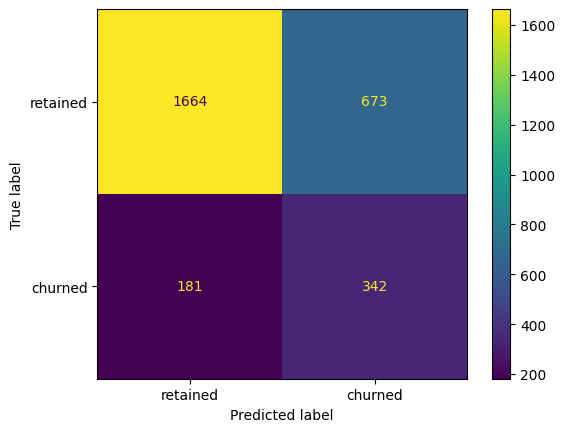

In [38]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['retained', 'churned'])
cm_display.plot()
plt.show()

The model predicted nearly four times as many false positives (673) as false negatives (181), and it correctly identified about 65.4% of the users who actually churned (342 out of 523).

### **Feature importance**

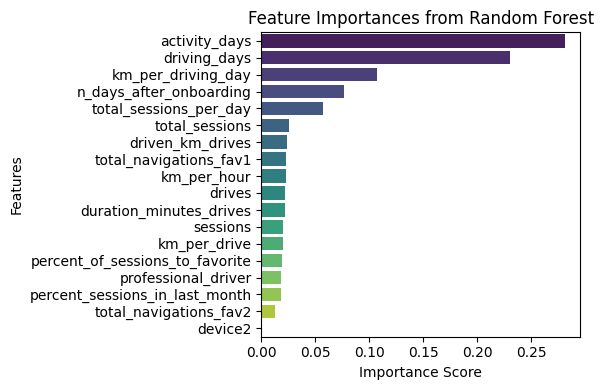

In [39]:
importances = pd.Series(RFC_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=importances.index, hue=importances.index, palette="viridis")
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

The Random Forest model relied on a broader range of features compared to the logistic regression model from the previous course, which primarily emphasized a single variable—activity_days. In contrast, the top features for the Random Forest included several engineered variables. This highlights just how impactful thoughtful feature engineering can be when it comes to improving model performance.

### **Conclusion**

Recommendation for churn prediction: The model has decent performance, especially with recall. However, precision and F1 scores need improvement. I would recommend using it with adjustments, such as fine-tuning hyperparameters or adding more features.

Tradeoff of splitting data: Splitting the data into training, validation, and test sets helps prevent overfitting and provides a more accurate measure of generalization. It ensures the model's robustness before final evaluation, unlike using just training and test sets.

Benefit of logistic regression: Logistic regression is simple and interpretable, which can be advantageous for understanding model behavior and explaining results to non-technical stakeholders.

Benefit of tree-based ensemble models: Tree-based models like Random Forest and XGBoost handle non-linearity and feature interactions better, making them more robust for complex datasets and typically offering higher predictive accuracy.

Improvement ideas: Improve the model by further tuning hyperparameters, balancing the dataset, using more advanced feature engineering, or trying different sampling techniques.

Additional features: Including features like user demographics, historical behavior, or sentiment from app feedback could further improve model accuracy and insights.